In [1]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=8ed2a10abf60665b4591da64bce356a7c223852978d2dc97be6422b6353685d4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 5.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string



In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


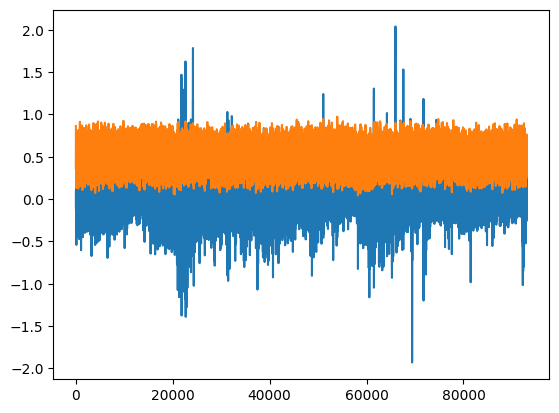

In [7]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
act_check = np.zeros(4)
act_check[1] = 1
act_check[2] = 1

print(np.sum(act_check)==2)

True


In [12]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(5)
    returns = np.array([])
    act_check = np.zeros(4)

    trade_timer = 0
    trade_value = 0.0
    trade_direction = 0
    cash_out_val = 0
    acount_bal = 0
    trade_max = 0
    trade_risk = 0
    ep_len = 60000


    for count in range(rand, rand+ep_len):
        state = np.concatenate((INDICATORS[count],trade_info))
        outputs = net.activate(state)
        risk =  np.clip(abs(outputs[4]), .01, 1)
        action = np.argmax(outputs[:4])
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count+1]
        cash_out_val = 0

        if buy:
          cash_out_val = trade_value
          trade_risk = risk
          trade_value = (cur_move*1)*trade_risk
          trade_direction = 1
          trade_timer = 0
          trade_max = trade_value
          act_check[0] = 1
        elif sell:
          cash_out_val = trade_value
          trade_risk = risk
          trade_value = (cur_move*-1)*trade_risk
          trade_direction = -1
          trade_timer = 0
          trade_max = trade_value
          act_check[1] = 1
        elif cash_out:
          cash_out_val = trade_value
          trade_timer = 0 if trade_direction != 0 else trade_timer+.05
          trade_value = 0
          trade_direction = 0
          trade_max = 0
          trade_risk = 0
          act_check[2] = 1
        else:
          trade_value += (cur_move*trade_direction)*trade_risk
          trade_timer += .05
          trade_max = max(trade_max,trade_value)
          act_check[3] = 1



        acount_bal += cash_out_val
        if buy or sell:
          acount_bal -= .05
        elif trade_value < 0:
          acount_bal -= .01
        else:
          acount_bal -= .005


        trade_info = np.array((trade_value,trade_direction,trade_timer,trade_max,trade_risk))


        if debug:
          print(trade_info)

        if acount_bal<-5 or (trade_timer>4 and trade_value<=0):
          return ((count-rand)/ep_len) if np.sum(act_check) == 4 else 0


    return ((count-rand)/ep_len) if np.sum(act_check) == 4 else 0

In [13]:
from numpy.random.mtrand import randint
def run_env_loop(net,rand,debug,ep_len,total_val):
    trade_info = np.zeros(5)
    returns = np.array([])
    act_check = np.zeros(4)

    trade_timer = 0
    trade_value = 0.0
    trade_direction = 0
    cash_out_val = 0
    acount_bal = 0
    trade_max = 0
    trade_risk = 0



    for count in range(rand, rand+ep_len):
        state = np.concatenate((INDICATORS[count],trade_info))
        outputs = net.activate(state)
        risk =  np.clip(abs(outputs[4]), .01, 1)
        action = np.argmax(outputs[:4])
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count+1]
        cash_out_val = 0
        random = randint(0,10)

        if buy:
          cash_out_val = trade_value*trade_risk
          trade_risk = risk
          trade_value = (cur_move*1)
          trade_direction = 1
          trade_timer = 0
          trade_max = trade_value
          act_check[0] = 1
        elif sell:
          cash_out_val = trade_value*trade_risk
          trade_risk = risk
          trade_value = (cur_move*-1)
          trade_direction = -1
          trade_timer = 0
          trade_max = trade_value
          act_check[1] = 1
        elif cash_out:
          cash_out_val = trade_value*trade_risk
          trade_timer = 0 if trade_direction != 0 else trade_timer+.05
          trade_value = 0
          trade_direction = 0
          trade_max = 0
          trade_risk = 0
          act_check[2] = 1
        else:
          trade_value += (cur_move*trade_direction)
          trade_timer += .05
          trade_max = max(trade_max,trade_value)
          act_check[3] = 1



        acount_bal += cash_out_val
        if buy or sell:
          acount_bal -= .05



        trade_info = np.array((trade_value,trade_direction,trade_timer,trade_max,trade_risk))


        if debug:
          print(trade_info)

        if acount_bal<-100:
          return acount_bal/total_val if np.sum(act_check) == 4 else -1
        elif trade_timer>2 and random == 2:
          return acount_bal/total_val if np.sum(act_check) == 4 else -1


    return acount_bal/total_val if np.sum(act_check) == 4 else -1

In [14]:
def eval_genomes(genomes, config):
  rand = random.randint(1000, 60000)
  ep_len = 10000
  sliced_arr = change[rand:rand+ep_len]
  total_val = sum(abs(sliced_arr))
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False,ep_len,total_val)


In [15]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [ ]:
winner = p.run(eval_genomes,1000)


 ****** Running generation 0 ****** 

Population's average fitness: -0.82105 stdev: 0.38195
Best fitness: 0.00287 - size: (5, 18) - species 1 - id 23
Average adjusted fitness: 0.178
Mean genetic distance 1.813, standard deviation 0.253
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 30.963 sec

 ****** Running generation 1 ****** 

Population's average fitness: -0.66407 stdev: 0.46808
Best fitness: 0.00148 - size: (5, 17) - species 1 - id 223
Average adjusted fitness: 0.335
Mean genetic distance 1.910, standard deviation 0.298
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 18.076 sec (24.520 average)

 ****** Running generation 2 ****** 

Population's average fitness: -0.73633 stdev: 0.43727
Best fitness: 0.00053 - size: (6, 18) - species 1 - id 272
Average adjusted fitness: 0.264
Mean genetic distance 1.865, standard deviation 0.323
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 21.278 sec (23.43

In [ ]:
net = neat.nn.FeedForwardNetwork.create(winner, config)
np.set_printoptions(formatter={'float': lambda x: "{:.4f}".format(x)})
rand = random.randint(1000, 60000)
ep_len = 10000
sliced_arr = change[rand:rand+ep_len]
total_val = sum(abs(sliced_arr))
run_env_loop(net,rand,True,ep_len,total_val)

In [ ]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [ ]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [ ]:
print(winner)

In [ ]:
for item in node_list:
       print(item)